In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from statsmodels.tools.eval_measures import mse, rmse

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings("ignore")

# Using Features to Predict Housing Prices
When predicting housing prices we can look at the data to see which features of a home drive a homes sell price.

## Data

Pulling the housing data from the thinkful database.


# Loading the Data

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# closing the connection to db
engine.dispose()

Here we pull the data from the thinkful database and then close the connection.

In [3]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [4]:
#profile

## Cleaning Data

Grabing a look at how the data is structured and the data types of each column.

In [5]:
df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [7]:
df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Isolating out the non continuous data columns from the continuous data columns.

In [8]:
non_cont = df.select_dtypes(['object']).columns
print(non_cont)
print('Number of none continuous columns: {}'.format(len(non_cont)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
Number of none continuous columns: 43


In [9]:
cont = df.select_dtypes(['int64', 'float64']).columns
print(cont)
print('Number of continuous columns: {}'.format(len(cont)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
Number of continuous columns: 38


In [10]:
# Removing saleprice and id from cont.
cont = cont.drop(['id','saleprice'])

Looking at the missing values in each column.

In [11]:
tmiss = df.isnull().sum().sort_values(ascending=False)
pmiss = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
dmiss = pd.concat([tmiss, pmiss], axis=1, keys=['Total', 'Percent'])
dmiss.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


Most of the missing is from the none continuous data.  This is consistent as you raise the total percentage that are missing.

In [12]:
tmiss_non_cont = dmiss.loc[non_cont.values]
tmiss_cont = dmiss.loc[cont.values]
print('Total missing above 10% that are none continuous: {}'.format(len(tmiss_non_cont.loc[tmiss_non_cont['Percent'] >= 0.1])))
print('Total missing above 10% that are continuous: {}'.format(len(tmiss_cont.loc[tmiss_cont['Percent'] >= 0.1])))
print('Total missing above 1% that are none continuous: {}'.format(len(tmiss_non_cont.loc[tmiss_non_cont['Percent'] >= 0.01])))
print('Total missing above 1% that are continuous: {}'.format(len(tmiss_cont.loc[tmiss_cont['Percent'] >= 0.01])))

Total missing above 10% that are none continuous: 5
Total missing above 10% that are continuous: 1
Total missing above 1% that are none continuous: 14
Total missing above 1% that are continuous: 2


Isolating all the data that is missing.

In [13]:
dmiss[dmiss['Percent'] > 0]

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


Lets take a look at all the null values and see if some can be salvaged, a lot of them have the same total of missing data.  Some of these can be grouped together as they are representing the same feature.

In [14]:
#Looking at null values of electrical column
df['electrical'][df['electrical'].isnull()]

1379    None
Name: electrical, dtype: object

Altho rare, this place probaly does not have any electrical, so the current value is correct.

In [15]:
#Looking at these features together since they represent each other
df[['masvnrtype', 'masvnrarea']][df['masvnrtype'].isnull()]

,masvnrtype,masvnrarea
235,None,NaN
529,None,NaN
650,None,NaN
936,None,NaN
973,None,NaN
977,None,NaN
1244,None,NaN
1278,None,NaN


These both match up perfectly indicating that the masvnrarea should be set to 0.0 as this column contains continuous data.

In [16]:
#Setting masvnrarea to 0.0
df['masvnrarea'].fillna(0, inplace = True)

In [17]:
#Grouping all the basement features together
df[['bsmtqual', 'bsmtcond', 'bsmtfintype1', 'bsmtfintype2', 'bsmtexposure']][df['bsmtexposure'].isnull()]

,bsmtqual,bsmtcond,bsmtfintype1,bsmtfintype2,bsmtexposure
17,None,None,None,None,None
39,None,None,None,None,None
90,None,None,None,None,None
100,None,None,None,None,None
103,None,None,None,None,None
157,None,None,None,None,None
183,None,None,None,None,None
260,None,None,None,None,None
343,None,None,None,None,None
363,None,None,None,None,None


All values are correct in their representation, some houses do not contain a basements and none of the values are NaN

In [18]:
#Grouping all the garage features together
df[['garagequal', 'garagefinish', 'garageyrblt', 'garagetype', 'garagecond', 'neighborhood']][df['garagecond'].isnull()]

,garagequal,garagefinish,garageyrblt,garagetype,garagecond,neighborhood
39,None,None,NaN,None,None,Edwards
48,None,None,NaN,None,None,OldTown
78,None,None,NaN,None,None,Sawyer
88,None,None,NaN,None,None,IDOTRR
89,None,None,NaN,None,None,CollgCr
...,...,...,...,...,...,...
1349,None,None,NaN,None,None,OldTown
1407,None,None,NaN,None,None,Mitchel
1449,None,None,NaN,None,None,MeadowV
1450,None,None,NaN,None,None,NAmes


Setting the garageyrblt to the mean year from the neighborhood the house is located and then rounding it to the whole number of the year.  All of the other features are represented accurately.

In [19]:
#Fill all the null years of garageyrblt to the mean and rounding to a whole number
#df.fillna(df.groupby('a').transform('mean'))
df['garageyrblt'] = df['garageyrblt'].fillna(df.groupby('neighborhood')['garageyrblt'].transform('mean').round(0))

Looking at the remainder of the data that contains null values as a 

In [20]:
#Grouping the remainder of the columns that contain null values
df[['lotfrontage', 'poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ']][df.isnull()]

,lotfrontage,poolqc,miscfeature,alley,fence,fireplacequ
0,NaN,None,None,None,None,None
1,NaN,None,None,None,None,None
2,NaN,None,None,None,None,None
3,NaN,None,None,None,None,None
4,NaN,None,None,None,None,None
...,...,...,...,...,...,...
1455,NaN,None,None,None,None,None
1456,NaN,None,None,None,None,None
1457,NaN,None,None,None,None,None
1458,NaN,None,None,None,None,None


All these values look correct, setting the continous column of lotfrontage to 0.0.

In [21]:
#Filling null values of lotfrontage to 0.0
df['lotfrontage'].fillna(0, inplace = True)

# Exploratory Data Analysis

Plotting out the Sale Price to look at the distribution.

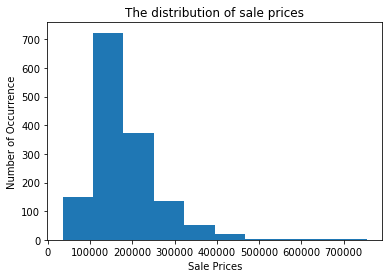

In [22]:
plt.hist(df['saleprice'])
plt.title('The distribution of sale prices')
plt.xlabel('Sale Prices')
plt.ylabel('Number of Occurrence')
plt.show()

There are some houses that seem to be in a very pricey range.  Looking at the mszoning to see if those are the commercial areas.

In [23]:
df['mszoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: mszoning, dtype: int64

mszoning value representation:
    C Commercial
    FV Floating Village Residential
    RH Residential High Density
    RL Residential Low Density
    RM Residential Medium Density

There are about 10 features that are commercial property.  Removing those.

In [24]:
#Select everything but commercial
df = df.loc[df['mszoning'] != 'C (all)',:]

In [25]:
df['mszoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: mszoning, dtype: int64

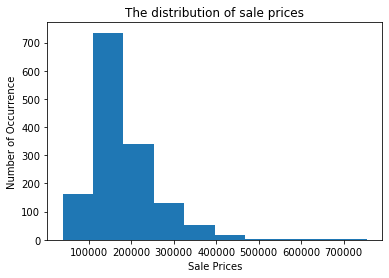

In [26]:
plt.hist(df['saleprice'])
plt.title('The distribution of sale prices')
plt.xlabel('Sale Prices')
plt.ylabel('Number of Occurrence')
plt.show()

Looking at the correlation of each data point in reference to saleprice.

### Univariate Analysis

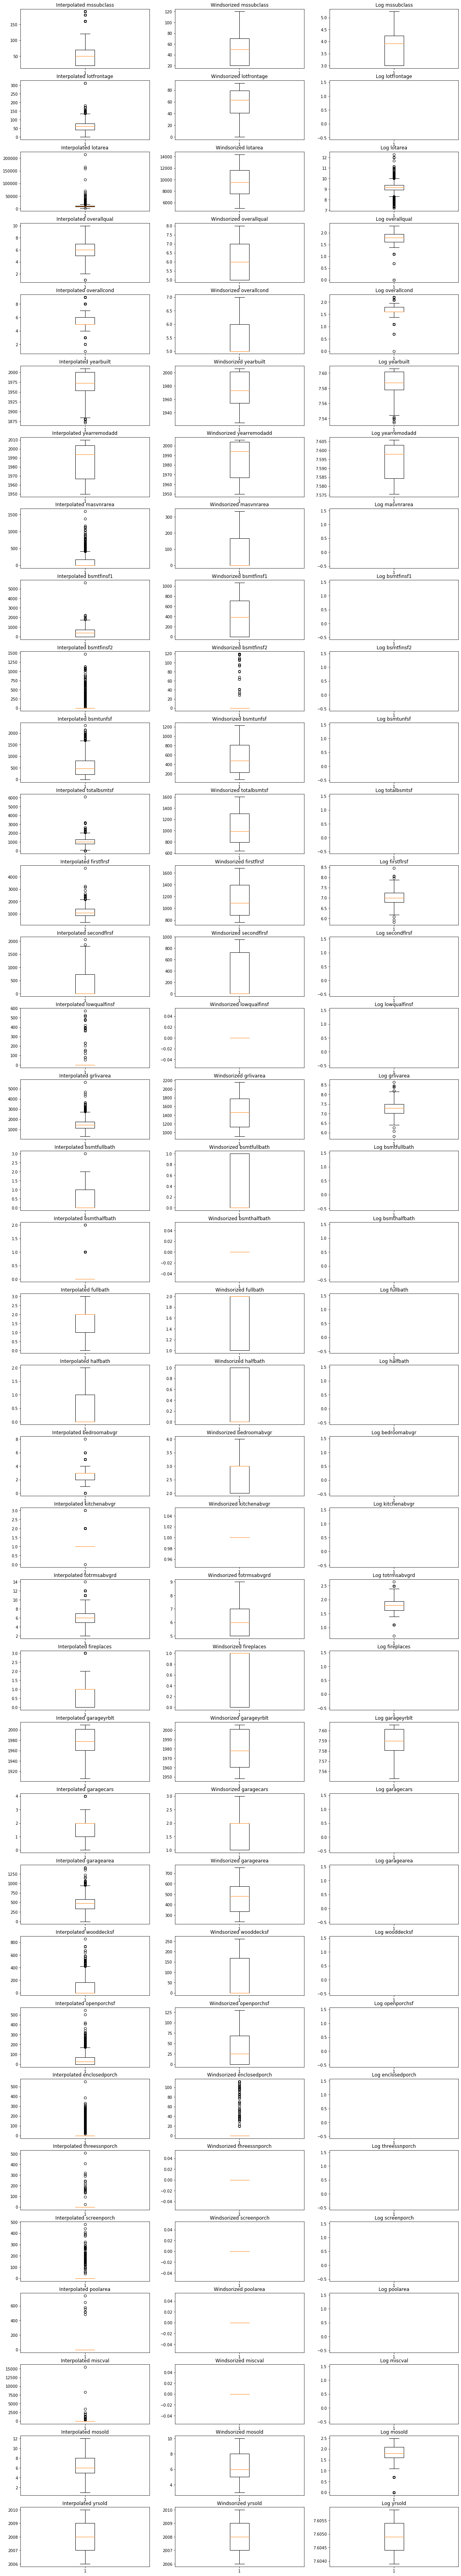

In [27]:
# Box plots to view the outliers and Winsorize
plt.figure(figsize=(20,120))
i = 1
z = len(cont)
for col in cont:
    d = df[col]
    # Ignoring Zeros
    l = np.log(d.replace(0, np.nan))

    plt.subplot(z, 3, i)
    plt.boxplot(d)
    plt.title('Interpolated ' + col)
    i += 1
    
    plt.subplot(z, 3, i)
    plt.boxplot(winsorize(d, (0.10, 0.10)))
    plt.title('Windsorized ' + col)
    i += 1
    
    plt.subplot(z, 3, i)
    plt.boxplot(l)
    plt.title('Log ' + col)
    i += 1
    
plt.show()

A lot of the features have outliers.  Many of them have feauters that are all zeros.

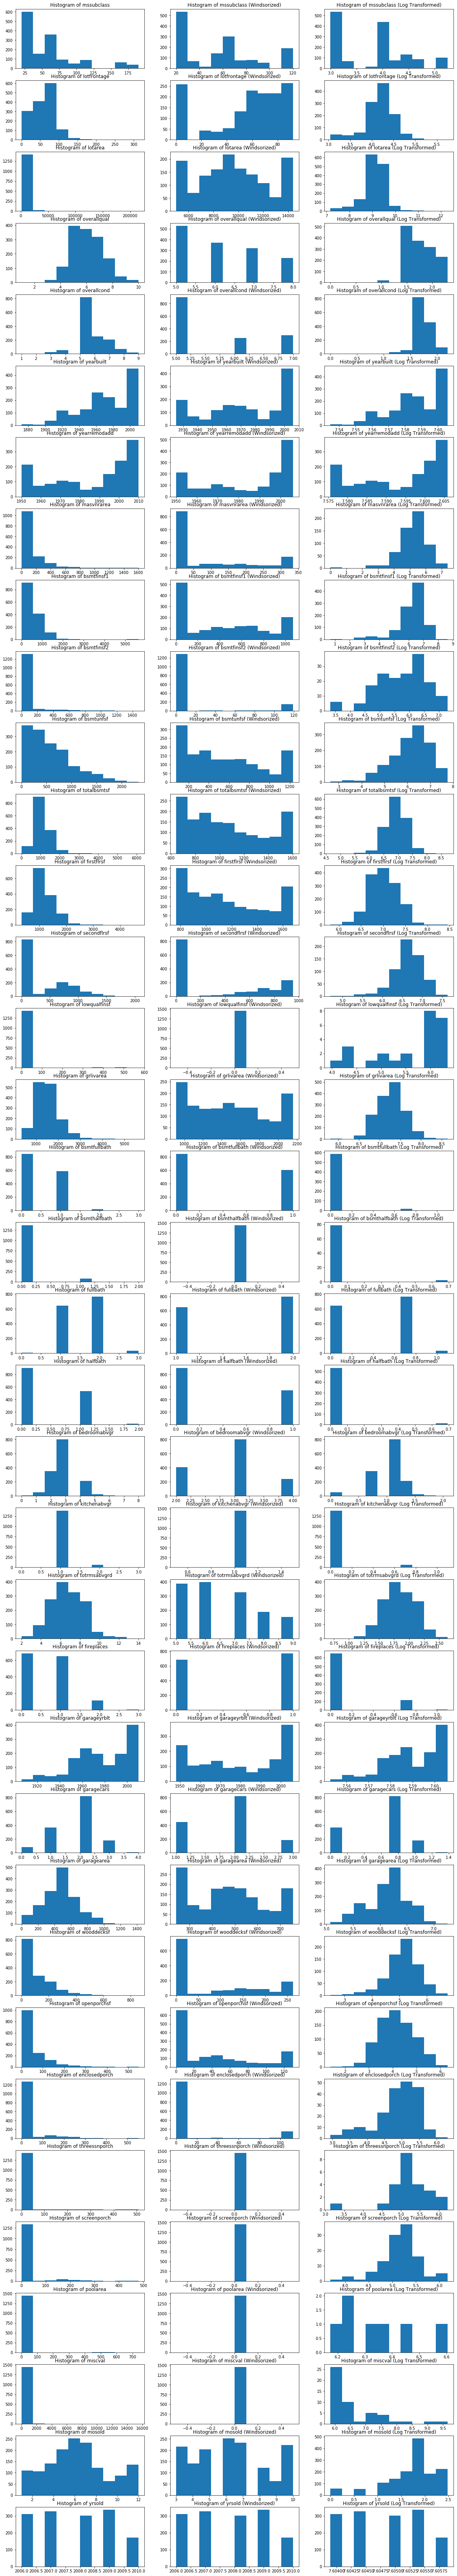

In [28]:
plt.figure(figsize=(20,120))
i = 1
z = len(cont)

for col in cont:
    d = df[col]
    # Ignoring Zeros with log calculation
    l = np.log(d.replace(0, np.nan))

    plt.subplot(z, 3, i)
    plt.hist(d)
    plt.title('Histogram of ' + col)
    i += 1
    
    plt.subplot(z, 3, i)
    plt.hist(winsorize(d, (0.10, 0.10)))
    plt.title('Histogram of ' + col + ' (Windsorized)')
    i += 1
    
    plt.subplot(z, 3, i)
    plt.hist(l)
    plt.title('Histogram of ' + col + ' (Log Transformed)')
    i += 1
    
plt.show()

Most of the features are highly skewed and a lot of them are normalized when the log is taken.

### Bivariate Analysis

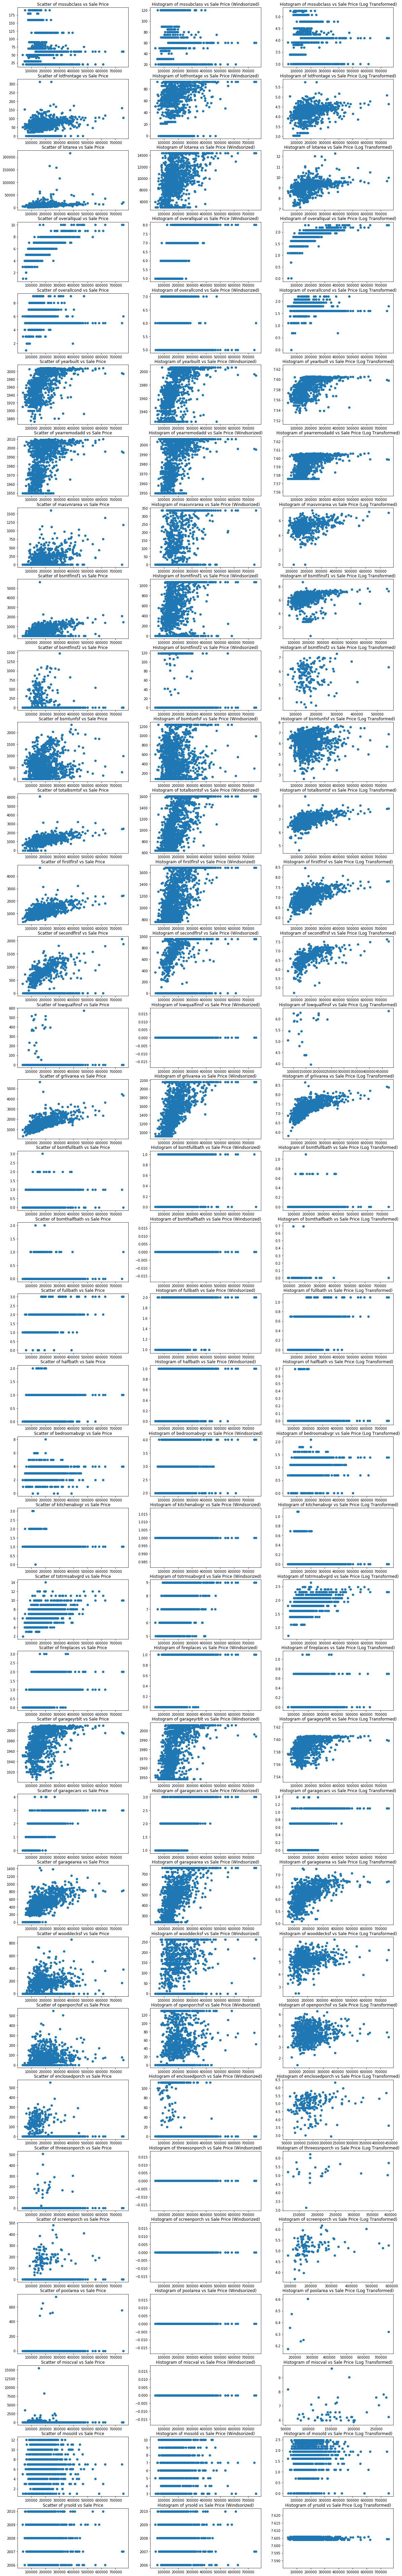

In [29]:
plt.figure(figsize=(20,140))
i = 1
z = len(cont)
for col in cont:
    d = df[col]
    # Ignoring Zeros with log calculation
    l = np.log(d.replace(0, np.nan))
    
    plt.subplot(z, 3, i)
    plt.scatter(df['saleprice'], d)
    plt.title('Scatter of ' + col + ' vs Sale Price')
    i += 1
    
    plt.subplot(z, 3, i)
    plt.scatter(df['saleprice'], winsorize(d, (0.10, 0.10)))
    plt.title('Histogram of ' + col + ' vs Sale Price (Windsorized)')
    i += 1
    
    plt.subplot(z, 3, i)
    plt.scatter(df['saleprice'], l)
    plt.title('Histogram of ' + col + ' vs Sale Price (Log Transformed)')
    i += 1
    
plt.show()

There is a correlation of some features having an effect of saleprice.

#### Correlation

In [30]:
corr = np.abs(df.iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)
corr

saleprice        1.000000
overallqual      0.789031
grlivarea        0.708658
garagecars       0.642135
garagearea       0.629831
totalbsmtsf      0.612088
firstflrsf       0.603300
fullbath         0.556674
totrmsabvgrd     0.533355
yearbuilt        0.517602
yearremodadd     0.501186
garageyrblt      0.498294
masvnrarea       0.471056
fireplaces       0.463264
bsmtfinsf1       0.384475
openporchsf      0.329491
wooddecksf       0.320770
secondflrsf      0.319774
halfbath         0.280882
lotarea          0.264715
bsmtfullbath     0.224054
bsmtunfsf        0.216152
lotfrontage      0.214273
bedroomabvgr     0.162008
kitchenabvgr     0.137825
enclosedporch    0.120765
screenporch      0.110540
poolarea         0.092396
overallcond      0.089084
mssubclass       0.087487
mosold           0.051987
threessnporch    0.043807
yrsold           0.025391
miscval          0.021052
lowqualfinsf     0.018755
bsmthalfbath     0.017561
bsmtfinsf2       0.014145
Name: saleprice, dtype: float64

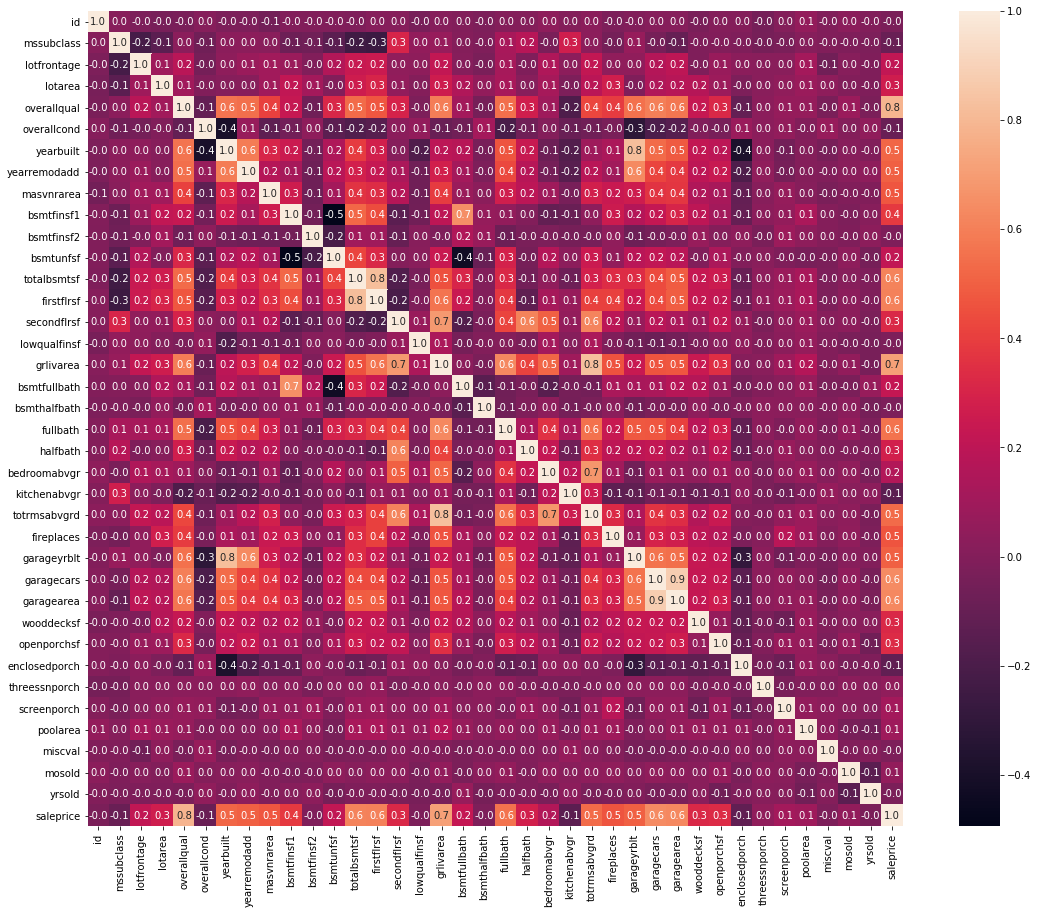

In [31]:
import seaborn as sns
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, square=True, fmt='.1f')

Going to use features overallqual, grlivarea, garagecars, garagearea, and totalbsmtsf from the continous data set.  And loading mszoning and street into 

## Feature Engineering

In [32]:
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix='mszoning', drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix='street', drop_first=True)], axis=1)
dummy_col_names = list(pd.get_dummies(df.mszoning, prefix='mszoning', drop_first=True).columns)
dummy_col_names = dummy_col_names + list(pd.get_dummies(df.street, prefix='street', drop_first=True).columns)
# Target variable set as Y
Y = df['saleprice']
# Feature set as X
X = df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_col_names]

## Regression Models

In [33]:
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     395.2
Date:                Wed, 15 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:07:36   Log-Likelihood:                -13911.
No. Observations:                1160   AIC:                         2.784e+04
Df Residuals:                    1150   BIC:                         2.789e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -7.6e+04   2.11e+04     -3.595      0.000   -1.17e+05   -3.45e+04
overallqual  2.331e+04   1245.354     18.717      0.000    2.09e+04    2.58e+04
grlivarea      43.8163      2.837     15.444      0.000      38.250      49.383
garagecars   1.583e+04   3385.942      4.674      0.000    9183.264    2.25e+04
garagearea      8.6158     11.983      0.719      0.472     -14.895      32.127
totalbsmtsf    28.2018      3.300      8.546      0.000      21.727      34.676
mszoning_RH -1.022e+04    1.2e+04     -0.854      0.393   -3.37e+04    1.33e+04
mszoning_RL  -685.7632   5702.349     -0.120      0.904   -1.19e+04    1.05e+04
mszoning_RM -1.893e+04   6416.383     -2.950      0.003   -3.15e+04   -6340.699
street_Pave -9717.4486   1.97e+04     -0.493      0.622   -4.84e+04    2.89e+04
==============================================================================
Omnibus:                      338.081   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36195.469
Skew:                           0.013   Prob(JB):                         0.00
Kurtosis:                      30.366   Cond. No.                     4.92e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared is at 0.756, means we are not matching about 24.4% of the target.

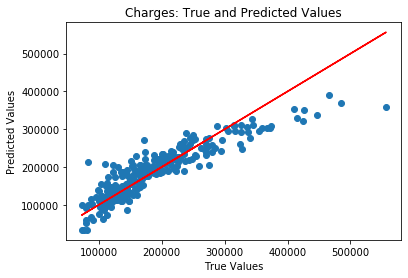

Mean absolute error of the prediction is: 24794.16220504084
Mean squared error of the prediction is: 1203406001.5165603
Root mean squared error of the prediction is: 34690.142713983754
Mean absolute percentage error of the prediction is: 14.63131658379925


In [34]:
# Setting predictions to y_preds
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Charges: True and Predicted Values')
plt.show()

print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

A lot of the data points are left outside of the predicted values.  This model does not fit that accurately.

In [35]:
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

df['int_over_sf'] = df['totalsf'] * df['overallqual']

# Y is the target variable
Y = np.log1p(df['saleprice'])
# X is the feature set
X = df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf'] + dummy_col_names]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     547.7
Date:                Wed, 15 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:07:36   Log-Likelihood:                 455.96
No. Observations:                1160   AIC:                            -889.9
Df Residuals:                    1149   BIC:                            -834.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.3613      0.104     99.975      0.000      10.158      10.565
overallqual     0.1803      0.009     20.117      0.000       0.163       0.198
grlivarea    6.987e-05   1.92e-05      3.643      0.000    3.22e-05       0.000
garagecars      0.0952      0.014      6.636      0.000       0.067       0.123
garagearea   6.751e-05   5.06e-05      1.334      0.182   -3.18e-05       0.000
totalsf         0.0003   2.55e-05     11.446      0.000       0.000       0.000
int_over_sf -2.377e-05   2.93e-06     -8.105      0.000   -2.95e-05    -1.8e-05
mszoning_RH    -0.1107      0.050     -2.211      0.027      -0.209      -0.012
mszoning_RL    -0.0243      0.024     -1.016      0.310      -0.071       0.023
mszoning_RM    -0.1768      0.027     -6.568      0.000      -0.230      -0.124
street_Pave    -0.0504      0.082     -0.612      0.541      -0.212       0.111
==============================================================================
Omnibus:                      342.478   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2986.646
Skew:                          -1.106   Prob(JB):                         0.00
Kurtosis:                      10.543   Cond. No.                     4.95e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

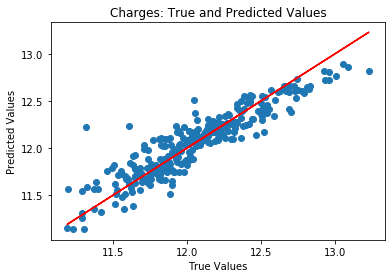

Mean absolute error of the prediction is: 0.11641015967655285
Mean squared error of the prediction is: 0.024641237216391165
Root mean squared error of the prediction is: 0.15697527581243859
Mean absolute percentage error of the prediction is: 0.9689828547170088


In [36]:
# Setting predictions to y_preds
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Charges: True and Predicted Values')
plt.show()

print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

A visual representation of the numbers reinforces that the second model is better at fitting the target.
The R-squared is higher then the first model, and the AIC and BIC are much lower then the first model, both are desirable making the second model more statisticaly significant.

In [37]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# Predictions
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print('R-squared of the model in training set is: {}'.format(lrm.score(X_train, y_train)))
print('-----Test set statistics-----')
print('R-squared of the model in test set is: {}'.format(lrm.score(X_test, y_test)))
print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8265972375621887
-----Test set statistics-----
R-squared of the model in test set is: 0.837071543166807
Mean absolute error of the prediction is: 0.11641015967631178
Mean squared error of the prediction is: 0.024641237216347426
Root mean squared error of the prediction is: 0.15697527581229925
Mean absolute percentage error of the prediction is: 0.9689828547152939


In [38]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# Predictions
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print('Best alpha value is: {}'.format(lasso_cv.alpha_))
print('R-squared of the model in training set is: {}'.format(lasso_cv.score(X_train, y_train)))
print('-----Test set statistics-----')
print('R-squared of the model in test set is: {}'.format(lasso_cv.score(X_test, y_test)))
print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8265579878574226
-----Test set statistics-----
R-squared of the model in test set is: 0.8373003167967895
Mean absolute error of the prediction is: 0.11619144278545901
Mean squared error of the prediction is: 0.024606637580440884
Root mean squared error of the prediction is: 0.1568650298200363
Mean absolute percentage error of the prediction is: 0.9672185812193254


In [39]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# Predictions
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print('Best alpha value is: {}'.format(ridge_cv.alpha_))
print('R-squared of the model in training set is: {}'.format(ridge_cv.score(X_train, y_train)))
print('-----Test set statistics-----')
print('R-squared of the model in test set is: {}'.format(ridge_cv.score(X_test, y_test)))
print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in training set is: 0.8265805514207172
-----Test set statistics-----
R-squared of the model in test set is: 0.8372822264044761
Mean absolute error of the prediction is: 0.11621519053560313
Mean squared error of the prediction is: 0.024609373564424275
Root mean squared error of the prediction is: 0.15687375039956264
Mean absolute percentage error of the prediction is: 0.9674020979688435


In [40]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# Predictions
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print('Best alpha value is: {}'.format(elasticnet_cv.alpha_))
print('R-squared of the model in training set is: {}'.format(elasticnet_cv.score(X_train, y_train)))
print('-----Test set statistics-----')
print('R-squared of the model in test set is: {}'.format(elasticnet_cv.score(X_test, y_test)))
print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8265860214452778
-----Test set statistics-----
R-squared of the model in test set is: 0.8372023414116782
Mean absolute error of the prediction is: 0.11628871245728359
Mean squared error of the prediction is: 0.024621455340044167
Root mean squared error of the prediction is: 0.1569122536325451
Mean absolute percentage error of the prediction is: 0.9680028486754841
